In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

In [78]:
df = pd.read_csv('pseudo_sigmoid_batches_long.csv')

In [79]:
df

,batch,data_point,value
0,Batch_1,0,0.031108
1,Batch_1,1,0.073149
2,Batch_1,2,0.000000
3,Batch_1,3,0.000000
4,Batch_1,4,0.075847
...,...,...,...
19995,Batch_20,995,0.972519
19996,Batch_20,996,0.997452
19997,Batch_20,997,0.986163
19998,Batch_20,998,0.987074


In [80]:
df_final = df.rename(columns = {'value':'Signal', 'data_point':'Volume', 'batch':'Batch'})
df_final["Campaign"] = "C1"
df_final


,Batch,Volume,Signal,Campaign
0,Batch_1,0,0.031108,C1
1,Batch_1,1,0.073149,C1
2,Batch_1,2,0.000000,C1
3,Batch_1,3,0.000000,C1
4,Batch_1,4,0.075847,C1
...,...,...,...,...
19995,Batch_20,995,0.972519,C1
19996,Batch_20,996,0.997452,C1
19997,Batch_20,997,0.986163,C1
19998,Batch_20,998,0.987074,C1


In [81]:
# Normalization as described in the "Moment Analysis" section
def normalize_signal(signal):
    return (signal - signal.min()) / (signal.max() - signal.min())


In [82]:
def calculate_derivative(volume, signal):
    # Smooth the signal first to reduce noise
    signal_smooth = savgol_filter(signal, window_length=11, polyorder=3)
    # Calculate the derivative
    dydx = np.gradient(signal_smooth, volume)
    return dydx

In [83]:
def calculate_transwidth(volume, signal):
    normalized_signal = normalize_signal(signal)
    cv_5 = np.interp(0.05, normalized_signal, volume)
    cv_95 = np.interp(0.95, normalized_signal, volume)
    return cv_95 - cv_5

In [84]:
def calculate_direct_af(volume, signal):
    normalized_signal = normalize_signal(signal)
    thresholds_low = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
    thresholds_high = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    cv_mid = np.interp(0.5, normalized_signal, volume)
    
    ratios = []
    for low, high in zip(thresholds_low, thresholds_high):
        cv_a = np.interp(low, normalized_signal, volume)
        cv_b = np.interp(high, normalized_signal, volume)
        ratios.append((cv_b - cv_mid) / (cv_mid - cv_a))
    
    return np.mean(ratios)

In [85]:
def analyze_chromatography(df, column_height):
    results = []
    
    for batch in df['Batch'].unique():
        batch_data = df[df['Batch'] == batch]
        volume = batch_data['Volume'].values
        signal = batch_data['Signal'].values
        
        
        # Calculate the derivative
        dydx = calculate_derivative(volume, signal)
        
        # Find the maximum of the derivative (steepest point of the S-curve)
        max_dydx_index = np.argmax(dydx)
        max_dydx = dydx[max_dydx_index]
        
        # Calculate metrics based on the derivative
        transwidth = calculate_transwidth(volume, signal)
        direct_af = calculate_direct_af(volume, signal)
        
        results.append({
            'Batch': batch,
            'Max_Slope': max_dydx,
            'Transwidth': transwidth,
            'Direct_Af': direct_af
        })
    
    return pd.DataFrame(results)

In [86]:
def establish_control_limits(metrics, n=15):
    control_limits = {}
    for column in metrics.columns:
        if column != 'Batch':
            data = metrics[column].iloc[:n]
            mean = data.mean()
            std = data.std()
            ucl = mean + 3 * std
            lcl = mean - 3 * std
            control_limits[column] = {'mean': mean, 'ucl': ucl, 'lcl': lcl}
    return control_limits

In [87]:
def create_control_charts(results, control_limits, original_df):
    # Merge the results with the original dataframe to get the Campaign information
    merged_results = pd.merge(results, original_df[['Batch', 'Campaign']].drop_duplicates(), on='Batch', how='left')
    
    metrics = ['Max_Slope', 'Transwidth', 'Direct_Af']
    
    # Create a color map based on unique campaigns
    unique_campaigns = merged_results['Campaign'].unique()
    n_colors = len(unique_campaigns)
    color_map = plt.cm.get_cmap('Dark2')  # You can change 'tab10' to other colormaps if needed
    colors = ListedColormap(color_map(np.linspace(0, 1, n_colors)))
    campaign_color_dict = dict(zip(unique_campaigns, colors.colors))
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 6*len(metrics)), sharex=True)
    fig.suptitle('Control Charts for Chromatography Metrics', fontsize=16)
    
    for ax, metric in zip(axes, metrics):
        data = merged_results[metric]
        batches = merged_results['Batch']
        campaigns = merged_results['Campaign']
        
        # Plot the metric values, colored by campaign
        for campaign in unique_campaigns:
            mask = campaigns == campaign
            ax.scatter(batches[mask], data[mask], c=[campaign_color_dict[campaign]], 
                       label=campaign)
        
        # Connect points with lines
        ax.plot(batches, data, color='black', alpha=0.3, zorder=1)
        
        # Plot control limits
        ax.axhline(y=control_limits[metric]['mean'], color='green', linestyle='--', label='Mean')
        ax.axhline(y=control_limits[metric]['ucl'], color='red', linestyle='--', label='UCL')
        ax.axhline(y=control_limits[metric]['lcl'], color='red', linestyle='--', label='LCL')
        
        # Highlight out-of-control points
        out_of_control = (data > control_limits[metric]['ucl']) | (data < control_limits[metric]['lcl'])
        ax.scatter(batches[out_of_control], data[out_of_control], 
                   facecolors='none', edgecolors='red', s=100, zorder=5, label='Out of Control')
        
        ax.set_title(f'Control Chart for {metric}')
        ax.set_ylabel(metric)
        
        # Create legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Handle x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    ax.set_xlabel('Batch')
    plt.tight_layout()
    plt.show()

/var/folders/3_/961pfffd04j0z8lxk9dhpftm0000gn/T/ipykernel_73129/919835720.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Dark2')  # You can change 'tab10' to other colormaps if needed


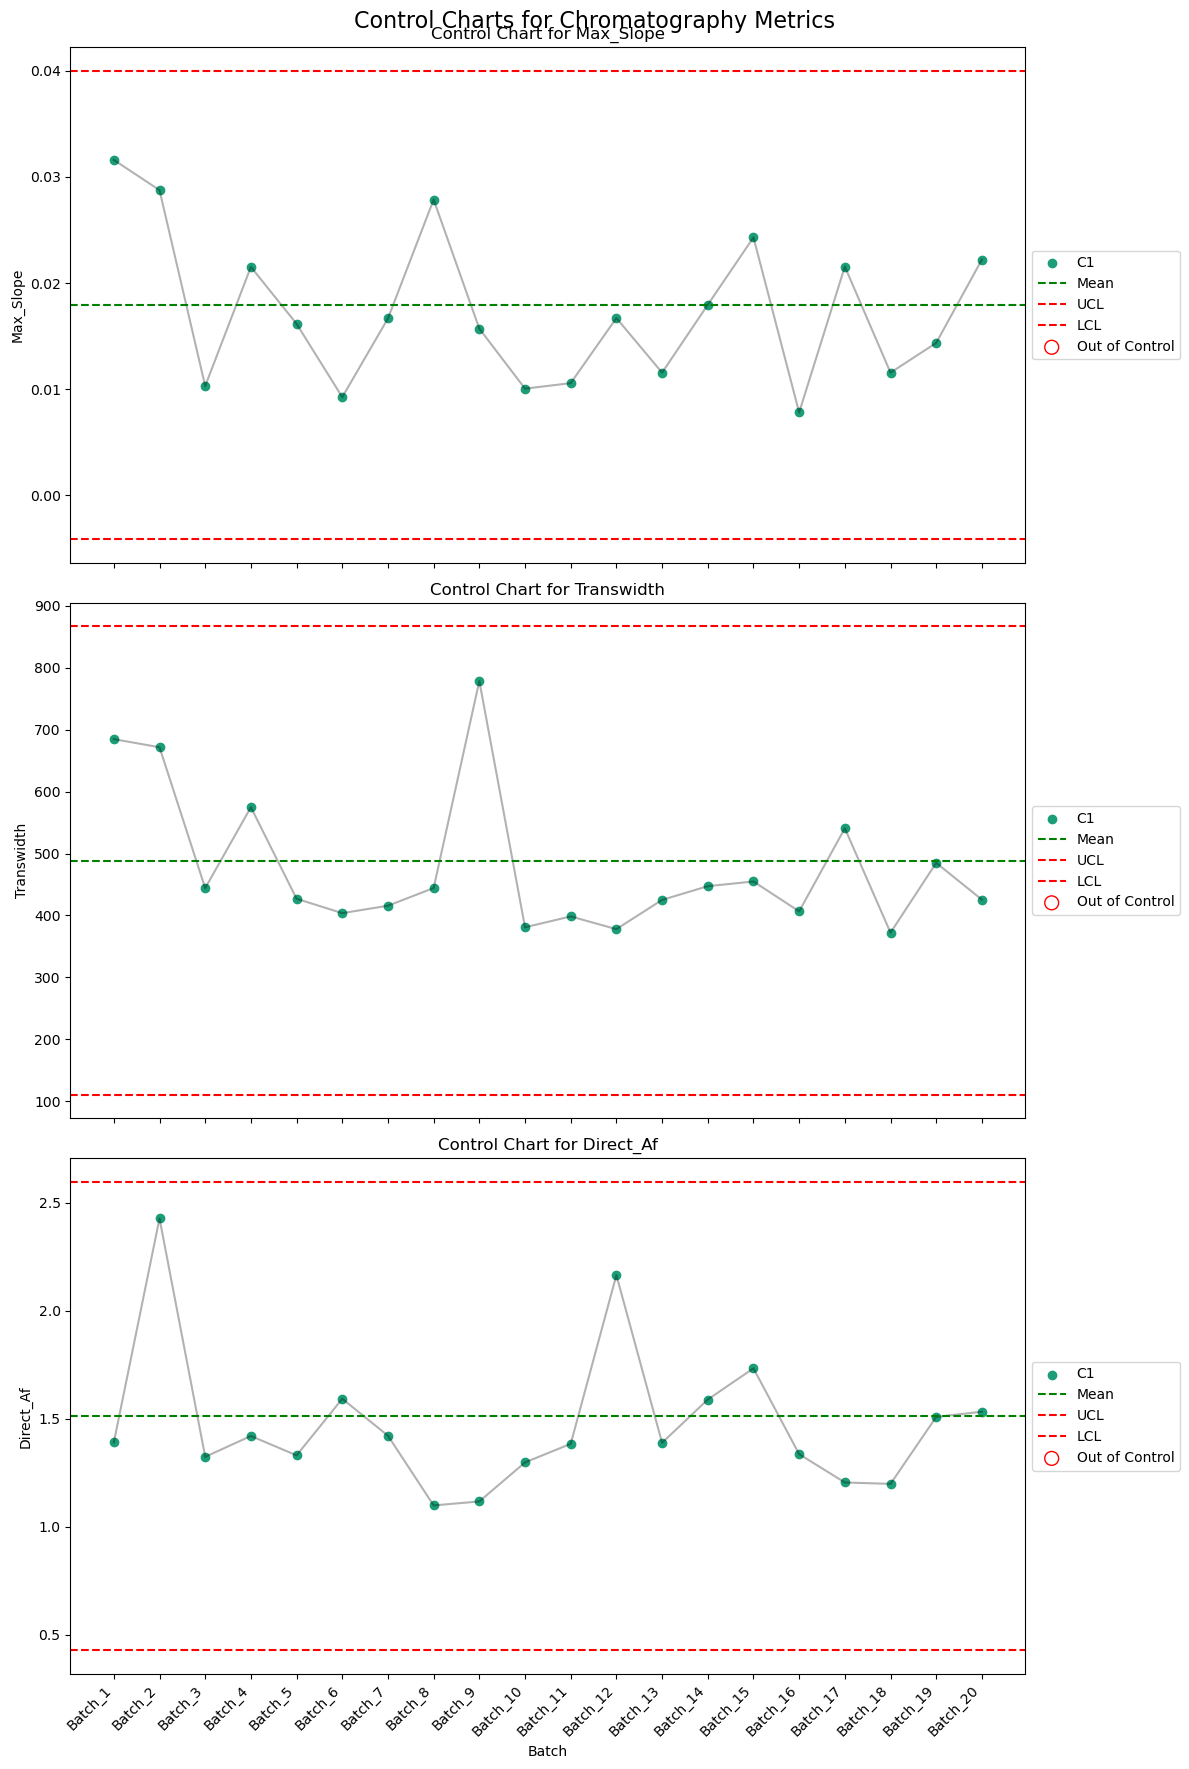

In [88]:
results = analyze_chromatography(df_final, 20)
control_limits = establish_control_limits(results)
create_control_charts(results, control_limits, df_final)